# __Step 4.6: 2D representation of docs__

Goals here:
- Use UMAP to plot relationships between:
  - Documents
  - Documents of different topics
  - Documents of the same topics but different time bins

Based on:
- [UMAP on sparse data](https://umap-learn.readthedocs.io/en/latest/sparse.html)

Issues:
- 2/9/23
  - The topic model was generated using older version of BERTopic and it cannot be loaded with the current version.
  - Try instead to get the topic assignment using the probability values.


## ___Set up___

In [21]:
import numpy as np
import scipy.sparse
import sympy
import sklearn.datasets
import sklearn.feature_extraction.text
import umap
import umap.plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import random
from matplotlib import colors
from bertopic import BERTopic
from pathlib import Path

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_6_umap"
work_dir.mkdir(parents=True, exist_ok=True)

# saved model, probability, and embedding files
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# topic overtime
dir44            = proj_dir / "4_topic_model/4_4_over_time"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Read data___

### Embeddings

In [3]:
with open(embedding_file, 'rb') as f:
    embeddings = pickle.load(f)

In [4]:
embeddings.shape

(421658, 768)

### Topic assignments

In [5]:
# The following lead to error
#IndexError: Failed in nopython mode pipeline (step: analyzing bytecode) pop from empty list
#topic_model = BERTopic.load(topic_model_file)

# load prob then figure out the topic from scratch instead
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

probability_threshold = np.percentile(probs, 95)
topics_assign = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]
topics_assign[:10]

[52, 48, 48, 48, 47, 32, 24, 48, 47, 52]

In [6]:
topics_array = np.array(topics_assign)
topics_array.shape

(421658,)

In [7]:
topics_array[1:10]

array([48, 48, 48, 47, 32, 24, 48, 47, 52])

## ___UMAP run___

### Functions

#### Read/generate UMAP fitted obj

In [53]:
def get_mapper(mapper_dir, n_neighbors=15, min_dist=0.1, metric='cosine', 
               random_state=seed):
  '''Read or generate UMAP fitted obj
  Args:
    mapper_dir (Posix path) - location where mapper file is or should be saved
    n_neighbors (int) - UMAP parameter, for constraining the size of the local 
      neighborhood UMAP will look at when attempting to learn the manifold 
      structure of the data
    min_dist (float) - UMAP parameter, minimum distance apart that points are 
      allowed to be in the low dimensional representation
  Return:
    mapper
  '''
  # Create dir if it does not exist
  mapper_dir.mkdir(parents=True, exist_ok=True)
  mapper_file = mapper_dir / 'mapper_topics_all.pickle'

  # read if exist
  if mapper_file.is_file():
    with open(mapper_file, "rb") as f:
      mapper = pickle.load(f)
  # else create mapper obj and save
  else:
    model  = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       metric=metric, random_state=random_state,
                       verbose=True)
    mapper = model.fit(embeddings)
    with open(mapper_file, "wb") as f:
      pickle.dump(mapper, f)

  return mapper

#### Get colors

In [46]:
# get colors
#To get color bins:
#https://stackoverflow.com/questions/69085926/have-each-histogram-bin-with-a-different-color
#Matplotlib color map
#https://matplotlib.org/stable/gallery/color/colormap_reference.html 
#RGB and RGBA
#https://matplotlib.org/stable/tutorials/colors/colors.html
# rgb or rgba won't work for color_keys later, need hex color
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex
def get_ckeys():
  cm = plt.cm.rainbow
  #cm = plt.cm.turbo
  #cm = plt.cm.hsv
  ckeys = {i:colors.to_hex(cm(i/91)) for i in range(-1,91)}
  return ckeys

#### Plotting all topics

In [41]:
# use default color map
#umap.plot.points(mapper, labels=topics_array)
#mapper_topics_all_plot = work_dir / 'fig_4_6_mapper_topics_all.pdf'

def plot_overall(mapper_dir, mapper, labels, color_key):
  umap.plot.points(mapper, labels=labels, color_key=color_key)
  mapper_topics_all_plot = mapper_dir / 'fig_4_6_mapper_topics_all.pdf'
  plt.savefig(mapper_topics_all_plot)

#### Plotting each topic

In [ ]:
def umap_plot_each(mapper_dir, mapper, labels, topic, c_fg, c_bg):
  
  color_key={f"topic={topic}":c_fg, "all_others":c_bg}

  umap.plot.points(mapper, labels=labels, color_key=color_key)
  mapper_topic_plot = mapper_dir / f'fig_4_6_mapper_topic_{topic}.pdf'
  plt.title(f'Topic {topic}')
  plt.savefig(mapper_topic_plot)
  plt.close()

In [ ]:
# go through topics
def plot_each(mapper_dir, mapper, toc_array, ckeys, c_fg="", c_bg="lightgray"):
  '''
  Args:
    mapper_dir (Path): directory of mapper object
    mapper (UMAP): mapper object
    toc_array (array): int array with topic indices
    ckeys (array): array of colors
    c_fg (str): foreground color, if not set, all topic colors will be the same
    c_bg (str): background color
  '''
  for topic in range(-1,90):
    toc_labels = []

    if c_fg == "":
      c_fg = ckeys[topic+1]

    # Modify labels
    for label in toc_array:
      if label == topic:
        toc_labels.append(f"topic={topic}")
      else:
        toc_labels.append("all_others")

    # Change label list into an array for umap.plot
    labels_array =  np.array(toc_labels)

    # Plotting
    umap_plot_each(mapper_dir, mapper, labels_array, topic, c_fg, c_bg)

### Default parameters

- n_neighbors=15
- min_dist = 0.1
- metric = 'cosine'

In [44]:
mapper_dir = work_dir / '_umap_default'
mapper_def = get_mapper(mapper_dir)

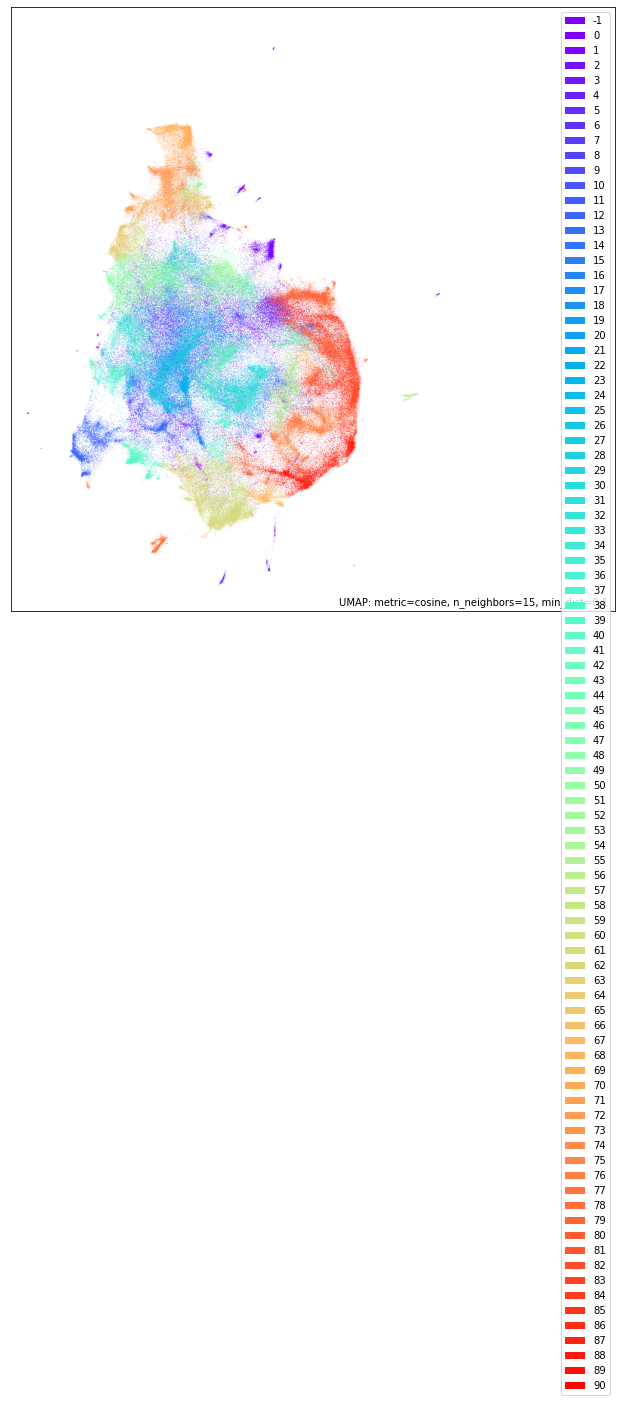

In [47]:
ckeys = get_ckeys()
plot_overall(mapper_dir, mapper_def, topics_array, ckeys)

In [48]:
plot_each(mapper_dir, mapper_def, topics_array, ckeys)

### Change n_neighbors

See [doc](https://umap-learn.readthedocs.io/en/latest/parameters.html)
- Controls how UMAP balances local versus global structure in the data
- By constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. 
  - Low values: force UMAP to concentrate on very local structure (potentially to the detriment of the big picture)
  - Large values: push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data."

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=10, random_state=20220609, verbose=True)
Thu Aug 10 13:04:42 2023 Construct fuzzy simplicial set
Thu Aug 10 13:04:43 2023 Finding Nearest Neighbors
Thu Aug 10 13:04:43 2023 Building RP forest with 37 trees
Thu Aug 10 13:05:41 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	Stopping threshold met -- exiting after 7 iterations
Thu Aug 10 13:06:07 2023 Finished Nearest Neighbor Search
Thu Aug 10 13:06:09 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Aug 10 13:13:59 2023 Finished embedding
Thu Aug 10 13:14:21 2023 Worst tree score: 0.15318339
Thu Aug 10 13:14:21 2023 Mean tree score: 0.15785811
Thu Aug 10 13:14:21 2023 Best tree score: 0.16246816
Thu Aug 10 13:14:28 2023 Forward diversification reduced edges from 4216580 to 2247453
Thu Aug 10 13:14:31 2023 Reverse diversification reduced edges from 2247453 to 2247453
Thu Aug 10 13:14:33 2023 Degree pruning reduced edges from 2724800 to 2631265
Thu Aug 10 13:14:33 2023 Resorting data and graph based on tree order
Thu Aug 10 13:14:34 2023 Building and compiling search function


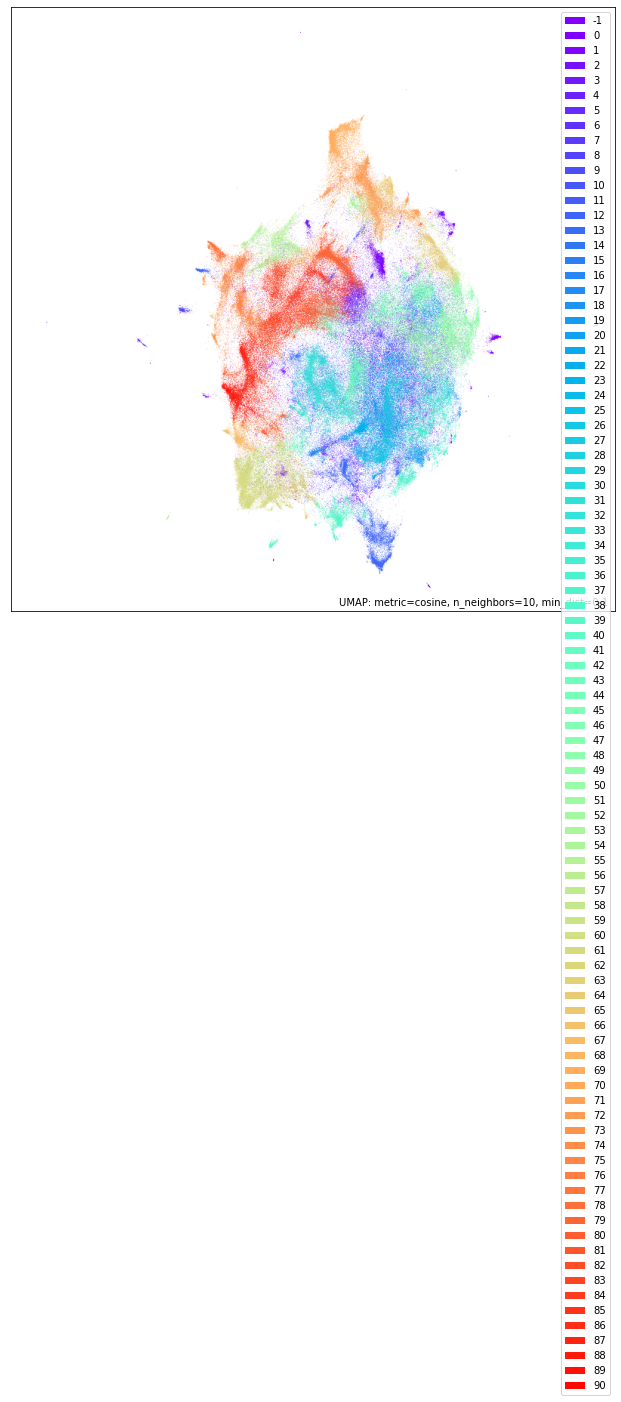

In [55]:
n_neighbors = 10
min_dist    = 0.1
metric      = 'cosine'

mapper_dir2 = work_dir / '_umap_nn10'
mapper_def2 = get_mapper(mapper_dir2, n_neighbors=n_neighbors)
plot_overall(mapper_dir2, mapper_def2, topics_array, ckeys)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=5, random_state=20220609, verbose=True)
Thu Aug 10 13:15:00 2023 Construct fuzzy simplicial set
Thu Aug 10 13:15:02 2023 Finding Nearest Neighbors
Thu Aug 10 13:15:02 2023 Building RP forest with 37 trees
Thu Aug 10 13:16:04 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	Stopping threshold met -- exiting after 6 iterations
Thu Aug 10 13:16:18 2023 Finished Nearest Neighbor Search
Thu Aug 10 13:16:19 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Aug 10 13:22:56 2023 Finished embedding
Thu Aug 10 13:23:13 2023 Worst tree score: 0.10425748
Thu Aug 10 13:23:13 2023 Mean tree score: 0.10799158
Thu Aug 10 13:23:13 2023 Best tree score: 0.11138411
Thu Aug 10 13:23:17 2023 Forward diversification reduced edges from 2108290 to 1505820
Thu Aug 10 13:23:17 2023 Reverse diversification reduced edges from 1505820 to 1505820
Thu Aug 10 13:23:17 2023 Degree pruning reduced edges from 1689736 to 1602237
Thu Aug 10 13:23:17 2023 Resorting data and graph based on tree order
Thu Aug 10 13:23:18 2023 Building and compiling search function


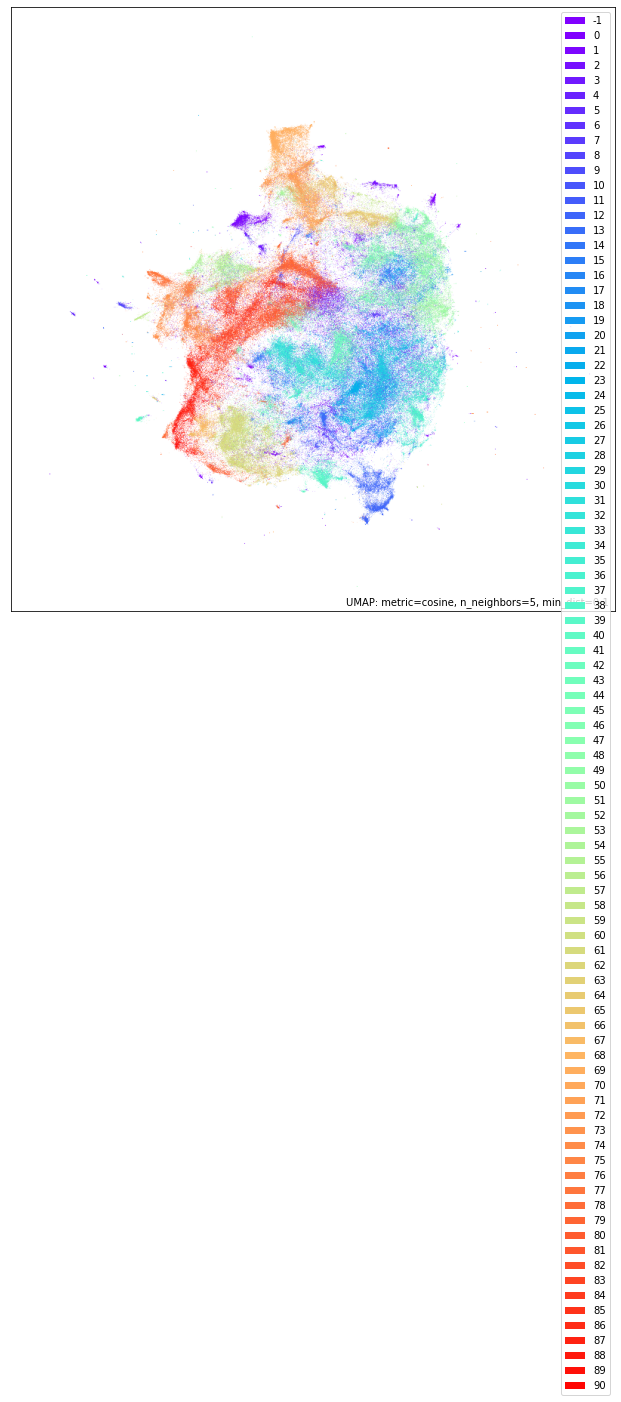

In [56]:
mapper_dir3 = work_dir / '_umap_nn5'
mapper_def3 = get_mapper(mapper_dir3, n_neighbors=5)
plot_overall(mapper_dir3, mapper_def3, topics_array, ckeys)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=40, random_state=20220609, verbose=True)
Thu Aug 10 13:24:21 2023 Construct fuzzy simplicial set
Thu Aug 10 13:24:22 2023 Finding Nearest Neighbors
Thu Aug 10 13:24:22 2023 Building RP forest with 37 trees
Thu Aug 10 13:25:13 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Thu Aug 10 13:26:39 2023 Finished Nearest Neighbor Search
Thu Aug 10 13:26:47 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Aug 10 13:36:17 2023 Finished embedding
Thu Aug 10 13:36:35 2023 Worst tree score: 0.46151146
Thu Aug 10 13:36:35 2023 Mean tree score: 0.47361042
Thu Aug 10 13:36:35 2023 Best tree score: 0.48661474
Thu Aug 10 13:36:40 2023 Forward diversification reduced edges from 16866320 to 4452521
Thu Aug 10 13:36:41 2023 Reverse diversification reduced edges from 4452521 to 4452509
Thu Aug 10 13:36:41 2023 Degree pruning reduced edges from 5774322 to 5768982
Thu Aug 10 13:36:41 2023 Resorting data and graph based on tree order
Thu Aug 10 13:36:42 2023 Building and compiling search function


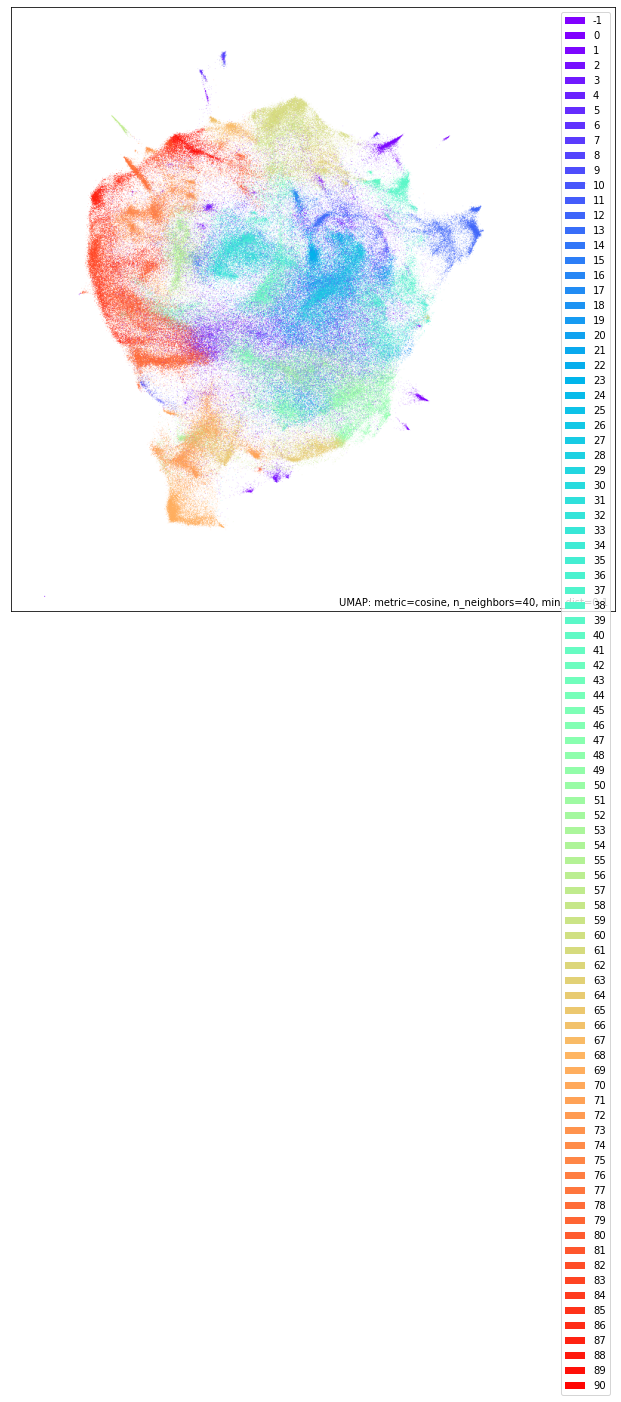

In [58]:
mapper_dir4 = work_dir / '_umap_nn40'
mapper_def4 = get_mapper(mapper_dir4, n_neighbors=40)
plot_overall(mapper_dir4, mapper_def4, topics_array, ckeys)

### Change n_neighbors and min_dist

`min_dist`:
- Controls how tightly UMAP is allowed to pack points together
- Provides the minimum distance apart that points are allowed to be in the low dimensional representation.
- Low values of min_dist will result in clumpier embeddings. 

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=5, random_state=20220609, verbose=True)
Thu Aug 10 13:37:07 2023 Construct fuzzy simplicial set
Thu Aug 10 13:37:08 2023 Finding Nearest Neighbors
Thu Aug 10 13:37:08 2023 Building RP forest with 37 trees
Thu Aug 10 13:38:01 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	Stopping threshold met -- exiting after 6 iterations
Thu Aug 10 13:38:13 2023 Finished Nearest Neighbor Search
Thu Aug 10 13:38:15 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Aug 10 13:43:34 2023 Finished embedding
Thu Aug 10 13:43:50 2023 Worst tree score: 0.10425748
Thu Aug 10 13:43:50 2023 Mean tree score: 0.10799158
Thu Aug 10 13:43:50 2023 Best tree score: 0.11138411
Thu Aug 10 13:43:52 2023 Forward diversification reduced edges from 2108290 to 1505820
Thu Aug 10 13:43:53 2023 Reverse diversification reduced edges from 1505820 to 1505820
Thu Aug 10 13:43:53 2023 Degree pruning reduced edges from 1689736 to 1602237
Thu Aug 10 13:43:53 2023 Resorting data and graph based on tree order
Thu Aug 10 13:43:53 2023 Building and compiling search function


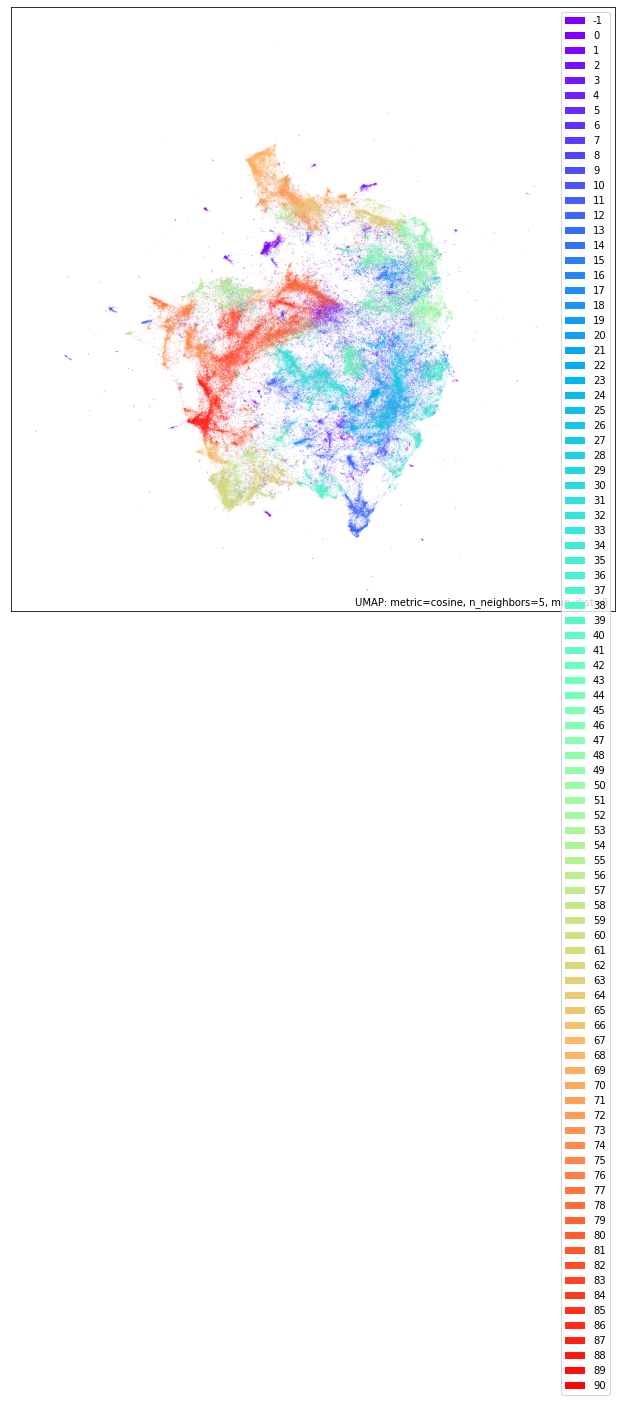

In [59]:
# n_neighbor = 5, min_dist = 0
mapper_dir5 = work_dir / '_umap_nn5_md0'
mapper_def5 = get_mapper(mapper_dir5, n_neighbors=5, min_dist=0)
plot_overall(mapper_dir5, mapper_def5, topics_array, ckeys)

In [60]:
# n_neighbor = 10, min_dist = 0
mapper_dir6 = work_dir / '_umap_nn10_md0'
mapper_def6 = get_mapper(mapper_dir6, n_neighbors=10, min_dist=0)
plot_overall(mapper_dir6, mapper_def6, topics_array, ckeys)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=10, random_state=20220609, verbose=True)
Thu Aug 10 13:44:16 2023 Construct fuzzy simplicial set
Thu Aug 10 13:44:17 2023 Finding Nearest Neighbors
Thu Aug 10 13:44:17 2023 Building RP forest with 37 trees
Thu Aug 10 13:45:09 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	Stopping threshold met -- exiting after 7 iterations
Thu Aug 10 13:45:31 2023 Finished Nearest Neighbor Search
Thu Aug 10 13:45:33 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

In [ ]:
# n_neighbor = 15, min_dist = 0
mapper_dir7 = work_dir / '_umap_nn15_md0'
mapper_def7 = get_mapper(mapper_dir7, n_neighbors=15, min_dist=0)
plot_overall(mapper_dir7, mapper_def7, topics_array, ckeys)

In [ ]:
# n_neighbor = 40, min_dist = 0
mapper_dir8 = work_dir / '_umap_nn40_md0'
mapper_def8 = get_mapper(mapper_dir8, n_neighbors=40, min_dist=0)
plot_overall(mapper_dir8, mapper_def8, topics_array, ckeys)

In [ ]:
# n_neighbor = 5, min_dist = 0.25
mapper_dir9 = work_dir / '_umap_nn5_md0.25'
mapper_def9 = get_mapper(mapper_dir9, n_neighbors=5, min_dist=0.25)
plot_overall(mapper_dir9, mapper_def9, topics_array, ckeys)

In [ ]:
# n_neighbor = 10, min_dist = 0.25
mapper_dir10 = work_dir / '_umap_nn10_md0.25'
mapper_def10 = get_mapper(mapper_dir10, n_neighbors=10, min_dist=0.25)
plot_overall(mapper_dir10, mapper_def10, topics_array, ckeys)

In [ ]:
# n_neighbor = 15, min_dist = 0.25
mapper_dir11 = work_dir / '_umap_nn15_md0.25'
mapper_def11 = get_mapper(mapper_dir11, n_neighbors=15, min_dist=0.25)
plot_overall(mapper_dir11, mapper_def11, topics_array, ckeys)

In [ ]:
# n_neighbor = 40, min_dist = 0.25
mapper_dir12 = work_dir / '_umap_nn40_md0.25'
mapper_def12 = get_mapper(mapper_dir12, n_neighbors=40, min_dist=0.25)
plot_overall(mapper_dir12, mapper_def12, topics_array, ckeys)

## ___Testing___

### Clustering prime numbers with UMAP

https://umap-learn.readthedocs.io/en/latest/sparse.html

In [2]:
primes = list(sympy.primerange(2, 110000))
prime_to_column = {p:i for i, p in enumerate(primes)}

In [5]:
lil_matrix_rows = []
lil_matrix_data = []
for n in range(100000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))
len(lil_matrix_rows), len(lil_matrix_data)

(100000, 100000)

In [8]:
factor_matrix = scipy.sparse.lil_matrix((len(lil_matrix_rows), len(primes)), 
                                        dtype=np.float32)

In [13]:
factor_matrix.rows = np.array(lil_matrix_rows)
factor_matrix.data = np.array(lil_matrix_data)

/tmp/ipykernel_21841/1462778770.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factor_matrix.rows = np.array(lil_matrix_rows)
/tmp/ipykernel_21841/1462778770.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factor_matrix.data = np.array(lil_matrix_data)


In [14]:
factor_matrix.shape

(100000, 10453)

In [15]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(
                                                                factor_matrix)

<AxesSubplot: >

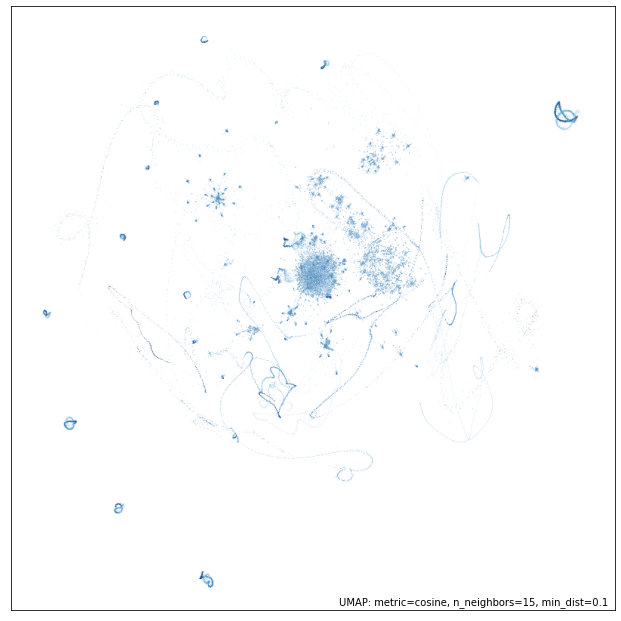

In [17]:
#umap.plot.points(mapper, values=np.arange(100000), theme='viridis')
umap.plot.points(mapper, values=np.arange(100000))

### Drawing each topic

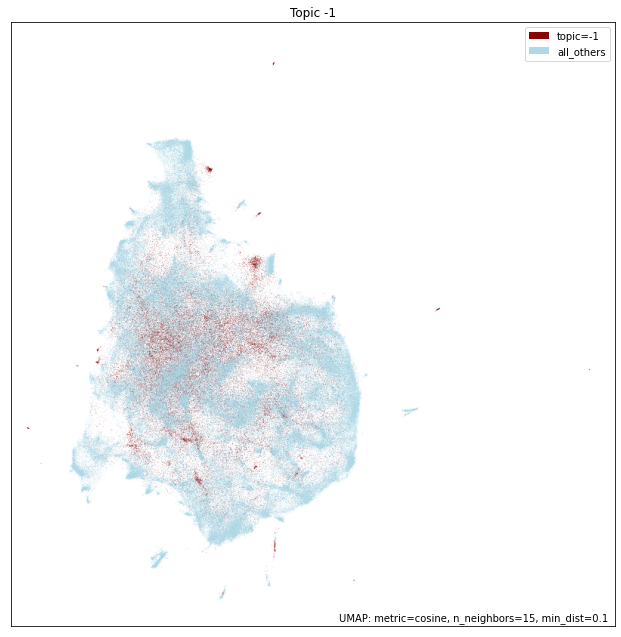

In [ ]:
topic_labels = []
topic = -1
for label in topics_array:
  if label == topic:
    topic_labels.append(f"topic={topic}")
  else:
    topic_labels.append("all_others")

labels_array =  np.array(topic_labels)

umap_plot_each(mapper, labels_array, topic)


### Color map

In [73]:
cmap = plt.cm.viridis
for i in range(0,10):
  print(cmap(1/10))

(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)


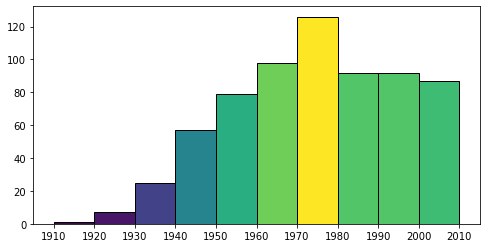

In [71]:
decades = np.arange(1910, 2020, 10)
data = np.random.gamma(4, scale=0.2, size=1000)*110+1910

fig, ax = plt.subplots(figsize=(8,4), facecolor='w')
cnts, values, bars = ax.hist(data, edgecolor='k', bins=decades)
ax.set_xticks(decades)
cmap = plt.cm.viridis

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(cnt/cnts.max()))

In [37]:
test = [colors.to_hex(plt.cm.rainbow(i/91)) for i in range(-1,91)]
len(test), test[:5]

(92, ['#8000ff', '#8000ff', '#7c06ff', '#7610ff', '#7019ff'])

In [38]:
test_copy = test.copy()
random.Random(seed).shuffle(test_copy)
len(test_copy), test_copy[:5]

(92, ['#99fca6', '#12c8e6', '#8000ff', '#abf69b', '#cbe486'])

In [39]:
random.Random(seed).shuffle(test)
len(test), test[:5]

# Ok, consistent

(92, ['#99fca6', '#12c8e6', '#8000ff', '#abf69b', '#cbe486'])

### umap.plot.points

In [20]:
help(umap.plot.points)

Help on function points in module umap.plot:

points(umap_object, labels=None, values=None, theme=None, cmap='Blues', color_key=None, color_key_cmap='Spectral', background='white', width=800, height=800, show_legend=True, subset_points=None, ax=None, alpha=None)
    Plot an embedding as points. Currently this only works
    for 2D embeddings. While there are many optional parameters
    to further control and tailor the plotting, you need only
    pass in the trained/fit umap model to get results. This plot
    utility will attempt to do the hard work of avoiding
    overplotting issues, and make it easy to automatically
    colour points by a categorical labelling or numeric values.
    
    This method is intended to be used within a Jupyter
    notebook with ``%matplotlib inline``.
    
    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP object that has a 2D embedding.
    
    labels: array, shape (n_samples,) (optional, default None)
        A

In [ ]:
ckeys = {-1:gray}
for topic, rgba in enumerate(rgbas):
  # background is set to (0,0,0) so need need to think about it
  #rgb_fore = rgba[:3]
  #alpha    = rgba[3]
  #rgb      = [rgb_f*alpha for rgb_f in rgb_fore]
  ckeys[topic] = rgba

### Deprecated get_ckeys

Was thinking to make neighboring topics have very distict colors, but this created a problem with too many similar colors ended up in wildly difference places. So not used.

The figure generated is in _umap_default:
- fig_4_6_mapper_topics_all_TEST_random_color_order.pdf

In [ ]:
# get colors
#To get color bins:
#https://stackoverflow.com/questions/69085926/have-each-histogram-bin-with-a-different-color
#Matplotlib color map
#https://matplotlib.org/stable/gallery/color/colormap_reference.html 
#RGB and RGBA
#https://matplotlib.org/stable/tutorials/colors/colors.html
# rgb or rgba won't work for color_keys later, need hex color
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex
def get_ckeys():
  '''
  Return:
    ckeys: {topic_idx: hex_color}
  '''

  cm = plt.cm.rainbow
  #cm = plt.cm.turbo
  #cm = plt.cm.hsv

  # get colors then randomized the color order, so topics with similar indices
  # will have more different colors
  #https://stackoverflow.com/questions/19306976/python-shuffling-with-a-parameter-to-get-the-same-result
  
  clist = [colors.to_hex(cm(i/91)) for i in range(-1,91)] # get color list
  random.Random(seed).shuffle(clist)                      # shuffle list

  # build color dictionary
  ckeys = {i:clist[i+1] for i in range(-1,91)}
  return ckeys